# 台灣板橋測站PM2.5濃度預測與異常偵測

## 專案簡介
本專案旨在利用台灣環境部公開的空氣品質監測數據，建立機器學習模型來預測板橋測站的PM2.5濃度。透過時間序列數據的處理、特徵工程與模型訓練，我們將分析PM2.5的變化趨勢，並評估模型的預測能力。此專案的成果可應用於空氣污染預警、環境健康風險評估及相關政策制定，為環境領域的AI應用提供實踐範例。

**主要步驟：**
1.  數據獲取與初步載入
2.  數據清洗與前處理
3.  探索性數據分析與特徵工程
4.  數據集劃分與再次處理缺失值
5.  模型訓練與評估 (使用 XGBoost 和 LightGBM)
6.  結果匯總與分析

## 步驟一：數據獲取與初步載入

本專案的數據來源為**台灣環境部環境資源資料庫** (空氣品質監測資料)，數據範圍涵蓋了約兩年的板橋測站每小時PM2.5濃度。原始數據以CSV/Excel格式下載並上傳至 Colab 環境。

此階段主要任務是將原始數據載入至 Pandas DataFrame，並進行初步檢視，了解其結構和包含的資訊。

In [12]:
import pandas as pd
file_path = '/content/即時值查詢.csv'
df = pd.read_csv(file_path, encoding='big5', skiprows=2)
print(df.head())
#df.info()

   測站          日期     測項  00 01 02 03 04 05 06  ...  14 15  16 17  18  19  20  \
0  板橋  2023/07/27  PM2.5   3  4  4  4  6  4  3  ...   9  6  10  8   4   2   3   
1  板橋  2023/07/28  PM2.5   3  0  2  3  3  3  3  ...   7  7   8  6   9  11  15   
2  板橋  2023/07/29  PM2.5  11  9  5  4  7  9  8  ...   7  8   8  9   9   9   8   
3  板橋  2023/07/30  PM2.5   0  2  4  4  6  7  7  ...  10  8   7  9  10   6   7   
4  板橋  2023/07/31  PM2.5   6  5  4  3  6  6  4  ...   8  7   5  2   4   6   8   

   21  22 23  
0   2   0  3  
1  14   9  9  
2  12  10  5  
3   8   6  3  
4   6   5  5  

[5 rows x 27 columns]


## 步驟二：數據清洗與前處理

原始數據的格式（日期與小時分開，PM2.5值為字串）不便於直接進行時間序列分析。此步驟旨在將數據轉換為標準的時間序列格式，並處理潛在的缺失值：

1.  **數據重塑 (Melt)**：將分散的小時欄位合併成單一的PM2.5值欄位，並創建一個獨立的小時欄位。
2.  **時間序列轉換**：將「日期」與「小時」欄位合併為單一的 `datetime` 類型索引。
3.  **數值轉換**：將PM2.5值轉換為浮點數 (`float64`)。
4.  **缺失值處理**：對於PM2.5數據中的缺失值，採用線性插值 (`interpolate(method='linear')`) 策略進行填充，以確保時間序列的連續性與完整性。
5.**極端異常值處理**：識別並處理那些遠超出合理物理範圍或極端異常的數值（例如，PM2.5濃度過高），將其替換為缺失值 (`NaN`)，以避免對模型訓練產生負面影響。

In [13]:
hour_cols = [f'{i:02d}' for i in range(24)]

df_long = df.melt(id_vars=['測站', '日期', '測項'],
                   value_vars=hour_cols,
                   var_name='小時',
                   value_name='PM2.5')

#print(df_long.head())
#df_long.info()

df_long['時間'] = pd.to_datetime(df_long['日期'] + ' ' + df_long['小時'].astype(str) + ':00:00',
                                 format='%Y/%m/%d %H:%M:%S')

df_long['PM2.5'] = pd.to_numeric(df_long['PM2.5'], errors='coerce')

df_long = df_long.set_index('時間').sort_index()

df_processed = df_long['PM2.5'].interpolate(method='linear')

print("\n處理缺失值後的PM2.5數據缺失值數量：", df_processed.isnull().sum())

final_df = pd.DataFrame({'PM2.5': df_processed})

print(final_df.head())
#final_df.info()


處理缺失值後的PM2.5數據缺失值數量： 0
                     PM2.5
時間                        
2023-07-27 00:00:00    3.0
2023-07-27 01:00:00    4.0
2023-07-27 02:00:00    4.0
2023-07-27 03:00:00    4.0
2023-07-27 04:00:00    6.0


PM2.5 描述性統計：
count    17568.000000
mean        11.203495
std          8.726157
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max        195.000000
Name: PM2.5, dtype: float64


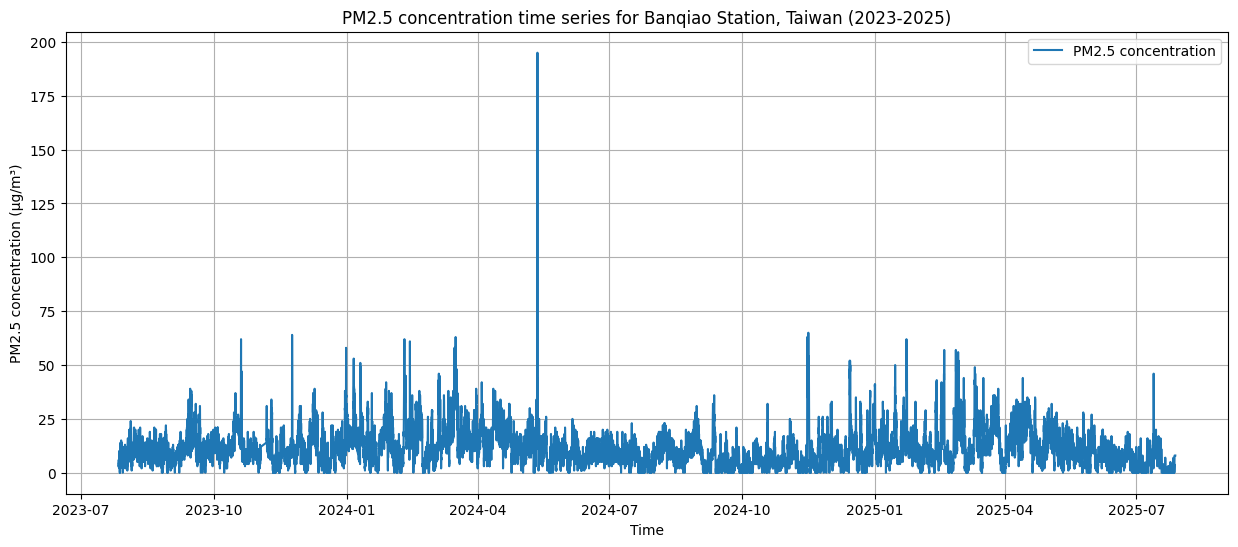

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

print("PM2.5 描述性統計：")
print(final_df['PM2.5'].describe())

# 1. 時間序列視覺化
plt.figure(figsize=(15, 6))
plt.plot(final_df.index, final_df['PM2.5'], label='PM2.5 concentration') #PM2.5 濃度
plt.title('PM2.5 concentration time series for Banqiao Station, Taiwan (2023-2025)') #台灣板橋測站 PM2.5 濃度時間序列 (2023-2025)
plt.xlabel('Time') #時間
plt.ylabel('PM2.5 concentration (μg/m³)') #PM2.5 濃度 (μg/m³)
plt.grid(True)
plt.legend()
plt.show()

PM2.5 值為 195 的數據點：


,PM2.5
時間,
2024-05-12 04:00:00,195.0



第一個 PM2.5 值為 195 的數據點 (2024-05-12 04:00:00) 前後數據：


,PM2.5
時間,
2024-05-11 23:00:00,22.0
2024-05-12 00:00:00,22.0
2024-05-12 01:00:00,29.0
2024-05-12 02:00:00,171.0
2024-05-12 03:00:00,171.0
2024-05-12 04:00:00,195.0
2024-05-12 05:00:00,69.0
2024-05-12 06:00:00,101.0
2024-05-12 07:00:00,37.0


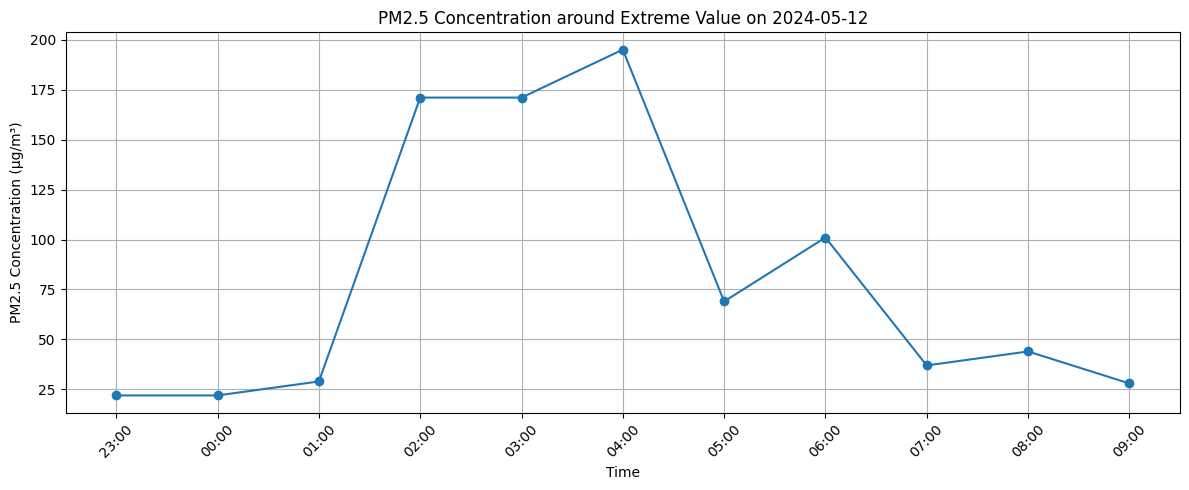

In [15]:
# 找出 PM2.5 值等於 195 的數據點
high_pm25_data = final_df[final_df['PM2.5'] == 195]

print("PM2.5 值為 195 的數據點：")
display(high_pm25_data)

# 查看這些數據點前後的數據，以了解當時的趨勢
# 例如，查看第一個高值數據點前後幾個小時的數據
if not high_pm25_data.empty:
    first_high_time = high_pm25_data.index[0]
    time_window = pd.Timedelta(hours=5) # 查看前後5小時的數據
    start_time = first_high_time - time_window
    end_time = first_high_time + time_window

    nearby_data = final_df.loc[start_time:end_time]

    print(f"\n第一個 PM2.5 值為 195 的數據點 ({first_high_time}) 前後數據：")
    display(nearby_data)

    plt.figure(figsize=(12, 5))
    plt.plot(nearby_data.index, nearby_data['PM2.5'], marker='o', linestyle='-') # 使用 nearby_data.index 作為 X 軸數據
    plt.title('PM2.5 Concentration around Extreme Value on 2024-05-12')
    plt.xlabel('Time')
    plt.ylabel('PM2.5 Concentration (μg/m³)')
    plt.xticks(nearby_data.index, [t.strftime('%H:%M') for t in nearby_data.index], rotation=45) # 顯示每小時的時間並格式化
    plt.grid(True)
    plt.tight_layout() # 自動調整佈局，防止標籤重疊
    plt.show()

else:
    print("\n數據中沒有 PM2.5 值為 195 的數據點。")

In [16]:
# 複製一份數據，以免修改原始數據
data_capped = final_df.copy()

# 計算 99th 百分位數作為上限閾值
upper_limit = data_capped['PM2.5'].quantile(0.99)
print(f"PM2.5 的 99th 百分位數 (上限閾值): {upper_limit:.2f}")

# 對大於上限閾值的數據進行轉換 (capping)
data_capped['PM2.5'] = data_capped['PM2.5'].clip(upper=upper_limit)

print("\n處理極端值後的 PM2.5 描述性統計：")
print(data_capped['PM2.5'].describe())

# 找出轉換後 PM2.5 值是否還包含原始極端值
# 這裡檢查轉換後的最大值是否是原始的 195 或被截斷的值
print(f"\n處理極端值後的最大 PM2.5 值: {data_capped['PM2.5'].max()}")

PM2.5 的 99th 百分位數 (上限閾值): 40.00

處理極端值後的 PM2.5 描述性統計：
count    17568.000000
mean        11.092725
std          8.070144
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         40.000000
Name: PM2.5, dtype: float64

處理極端值後的最大 PM2.5 值: 40.0


## 步驟三：探索性數據分析 (EDA) 與特徵工程

在建立模型之前，進行探索性數據分析以理解PM2.5數據的模式至關重要。我們透過視覺化觀察數據的趨勢、一個月每一週的變化和兩年內每個星期幾的平均PM2.5濃度。

此外，為了提升模型預測的準確性，我們從時間序列中提取了多個有用的特徵：
* **時間相關特徵**：小時 (hour)、星期幾 (day_of_week)、一年中的第幾天 (day_of_year)、月份 (month)、年份 (year)、一年中的第幾週 (week_of_year)。
* **季節特徵**：將月份映射為春、夏、秋、冬四季。
* **滯後特徵 (Lag Features)**：過去的PM2.5值是預測未來的重要參考。我們添加了前1小時 (`PM2.5_lag1`)、前24小時 (`PM2.5_lag24`) 和前168小時 (一週前，`PM2.5_lag168`) 的PM2.5值。
* **滾動統計特徵 (Rolling Statistics)**：計算了過去24小時的PM2.5平均值 (`PM2.5_rolling_mean_24hr`)，以捕捉短期波動。

特徵工程後，由於滯後和滾動計算，數據開頭會產生少量的 NaN 值。接續進行步驟2移除這些包含 NaN 的行，以確保數據完整性。

這些特徵將作為機器學習模型的輸入，幫助模型學習PM2.5的複雜變化模式。

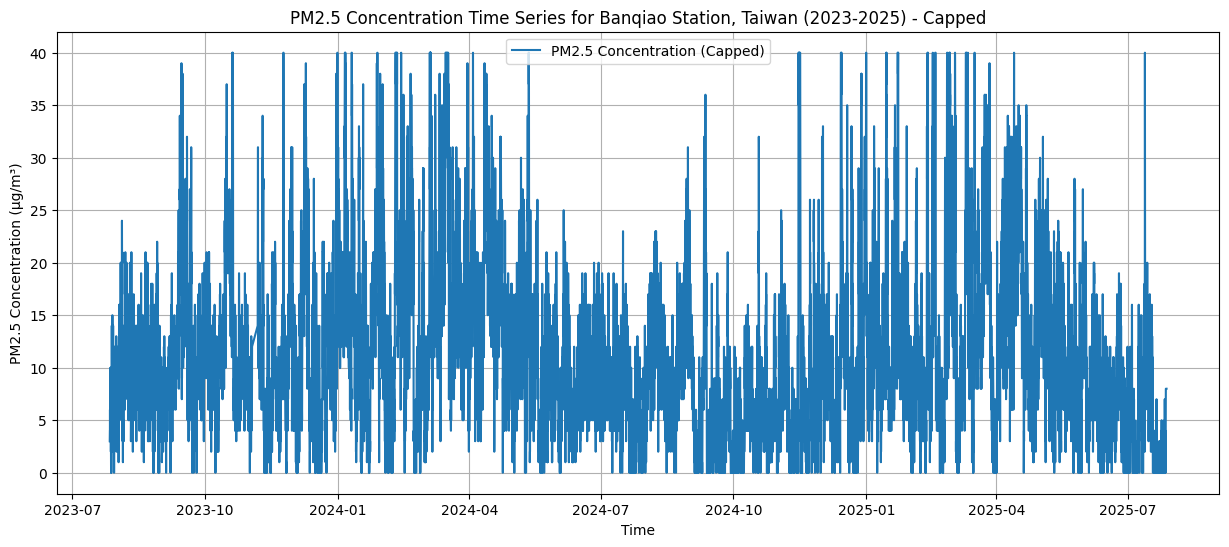


First 5 rows of data after adding features (Note leading NaNs due to lag and rolling calculations):
                     PM2.5  hour  day_of_week  day_of_year  month  year  \
時間                                                                        
2023-07-27 00:00:00    3.0     0            3          208      7  2023   
2023-07-27 01:00:00    4.0     1            3          208      7  2023   
2023-07-27 02:00:00    4.0     2            3          208      7  2023   
2023-07-27 03:00:00    4.0     3            3          208      7  2023   
2023-07-27 04:00:00    6.0     4            3          208      7  2023   

                     week_of_year  season  PM2.5_lag1  PM2.5_lag24  \
時間                                                                   
2023-07-27 00:00:00            30  Summer         NaN          NaN   
2023-07-27 01:00:00            30  Summer         3.0          NaN   
2023-07-27 02:00:00            30  Summer         4.0          NaN   
2023-07-27 03:00:00    

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(data_capped.index, data_capped['PM2.5'], label='PM2.5 Concentration (Capped)') # PM2.5 濃度 (處理極端值後)
plt.title('PM2.5 Concentration Time Series for Banqiao Station, Taiwan (2023-2025) - Capped') # 台灣板橋測站 PM2.5 濃度時間序列 (2023-2025) - 處理極端值後
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration (μg/m³)')
plt.grid(True)
plt.legend()
plt.show()

# 步驟1. Feature Engineering
# 從處理過極端值的 data_capped DataFrame 開始進行特徵工程
data = data_capped.copy() # 複製一份數據以進行特徵工程，不影響原始數據

# 從時間索引提取特徵
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek # 0=Monday, 6=Sunday
data['day_of_year'] = data.index.dayofyear
data['month'] = data.index.month
data['year'] = data.index.year
data['week_of_year'] = data.index.isocalendar().week.astype(int) # Use isocalendar().week to get week number

# Consider seasonality (e.g., simply divide into Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug), Autumn (Sep-Nov))
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
data['season'] = data['month'].apply(get_season)

# 添加滯後特徵 (Lag features) - 過去的PM2.5值
# 前1小時的PM2.5值
data['PM2.5_lag1'] = data['PM2.5'].shift(1)
# 前24小時 (前一天) 的PM2.5值
data['PM2.5_lag24'] = data['PM2.5'].shift(24)
# 前7天 (168小時) 的PM2.5值
data['PM2.5_lag168'] = data['PM2.5'].shift(168)

# 添加滾動統計特徵 (Rolling statistics) - e.g., mean of past 24 hours
data['PM2.5_rolling_mean_24hr'] = data['PM2.5'].rolling(window=24).mean()

print("\nFirst 5 rows of data after adding features (Note leading NaNs due to lag and rolling calculations):") # 添加特徵後的數據前5行 (注意開頭的 NaN 是由於滯後和滾動計算造成的)
print(data.head())
print("\nInformation of data after adding features:") # 添加特徵後的數據資訊
data.info()
print("\nNumber of missing values (after feature engineering):") # 缺失值數量 (特徵工程後)
print(data.isnull().sum())

# 步驟2. 處理特徵工程後產生的缺失值 (主要是滯後和滾動特徵)
# 由於這些缺失值主要在時間序列的開頭，直接刪除包含 NaN 的行是常見且有效的方法
data_cleaned = data.dropna()

print("\n刪除缺失值後的數據前5行：")
print(data_cleaned.head())
print("\n刪除缺失值後的數據缺失值數量：")
print(data_cleaned.isnull().sum().sum()) # 檢查整個DataFrame是否還有NaN

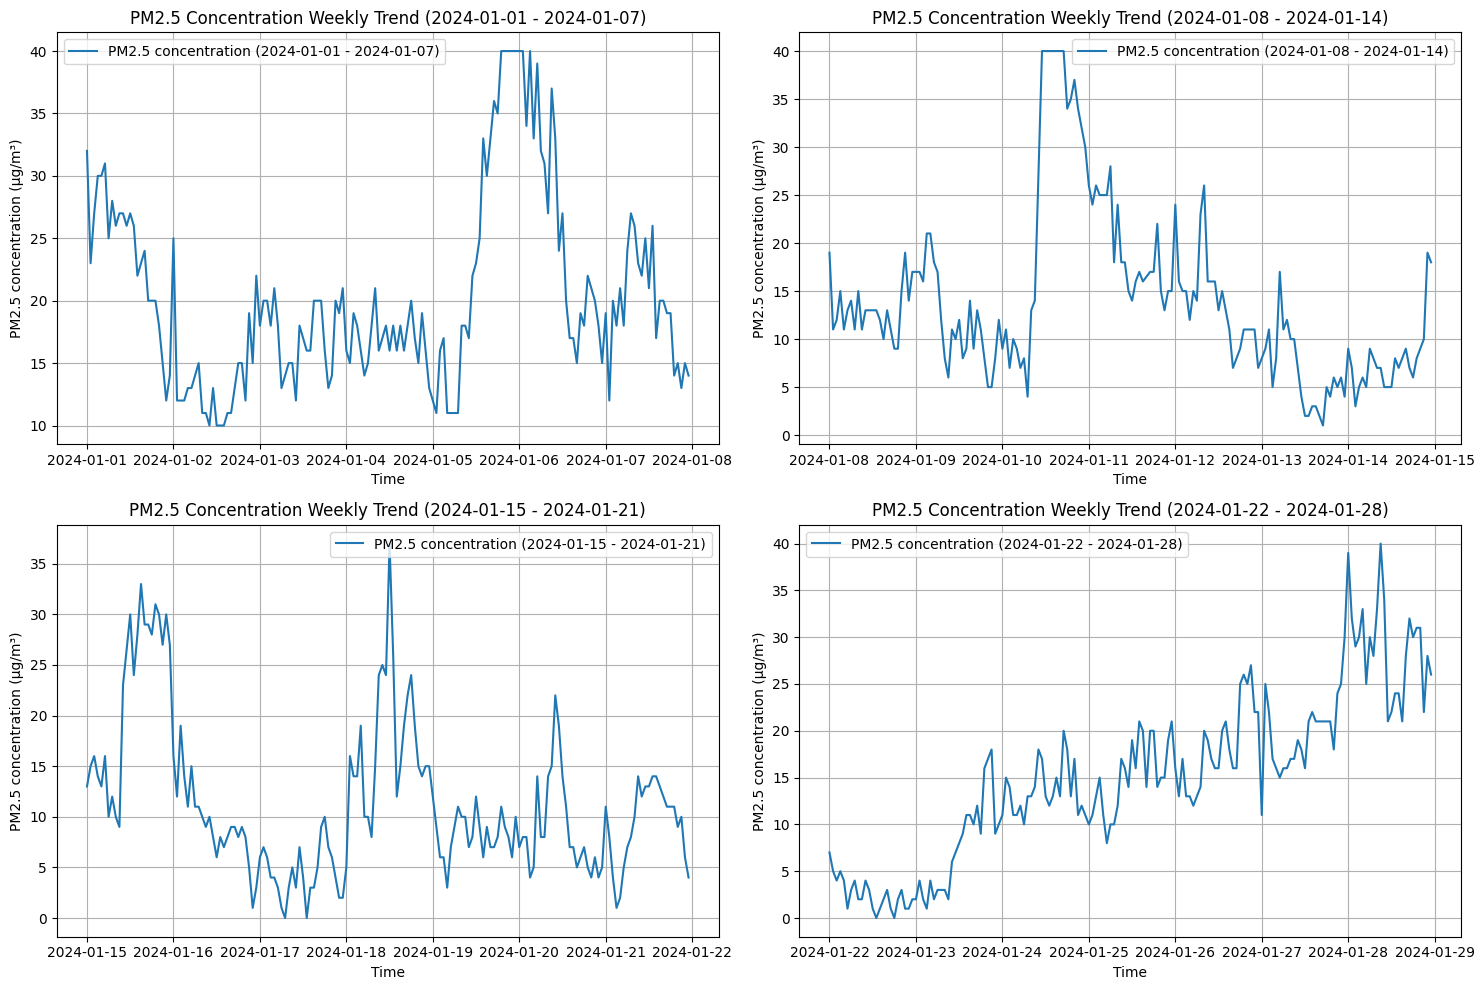

In [18]:
# 觀察2024 年 1 月的每周變化
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

# 2024 年 1 月的第一週
start_date_1 = '2024-01-01'
end_date_1 = '2024-01-07'

axes[0][0].plot(data['PM2.5'].loc[start_date_1:end_date_1].index, # X 軸數據 (時間索引)
                 data['PM2.5'].loc[start_date_1:end_date_1].values, # Y 軸數據 (PM2.5 值)
                 label=f'PM2.5 concentration ({start_date_1} - {end_date_1})')
axes[0][0].set_title(f'PM2.5 Concentration Weekly Trend ({start_date_1} - {end_date_1})') # 台灣板橋測站 PM2.5 濃度週趨勢
axes[0][0].set_xlabel('Time') # 時間
axes[0][0].set_ylabel('PM2.5 concentration (μg/m³)') # PM2.5 濃度 (μg/m³)
axes[0][0].grid(True)
axes[0][0].legend()

# 2024 年 1 月的第二週
start_date_2 = '2024-01-08'
end_date_2 = '2024-01-14'
# 使用 axes[0][1] 在右上角子圖上繪製
axes[0][1].plot(data['PM2.5'].loc[start_date_2:end_date_2].index,
                 data['PM2.5'].loc[start_date_2:end_date_2].values,
                 label=f'PM2.5 concentration ({start_date_2} - {end_date_2})')
axes[0][1].set_title(f'PM2.5 Concentration Weekly Trend ({start_date_2} - {end_date_2})') # 台灣板橋測站 PM2.5 濃度週趨勢
axes[0][1].set_xlabel('Time') # 時間
axes[0][1].set_ylabel('PM2.5 concentration (μg/m³)') # PM2.5 濃度 (μg/m³)
axes[0][1].grid(True)
axes[0][1].legend()

# 2024 年 1 月的第三週
start_date_3 = '2024-01-15'
end_date_3 = '2024-01-21'
# 使用 axes[1][0] 在左下角子圖上繪製
axes[1][0].plot(data['PM2.5'].loc[start_date_3:end_date_3].index,
                 data['PM2.5'].loc[start_date_3:end_date_3].values,
                 label=f'PM2.5 concentration ({start_date_3} - {end_date_3})')
axes[1][0].set_title(f'PM2.5 Concentration Weekly Trend ({start_date_3} - {end_date_3})') # 台灣板橋測站 PM2.5 濃度週趨勢
axes[1][0].set_xlabel('Time') # 時間
axes[1][0].set_ylabel('PM2.5 concentration (μg/m³)') # PM2.5 濃度 (μg/m³)
axes[1][0].grid(True)
axes[1][0].legend()

# 2024 年 1 月的第四週
start_date_4 = '2024-01-22'
end_date_4 = '2024-01-28'
# 使用 axes[1][1] 在右下角子圖上繪製
axes[1][1].plot(data['PM2.5'].loc[start_date_4:end_date_4].index, # 修正變數名稱為 start_date_4
                 data['PM2.5'].loc[start_date_4:end_date_4].values, # 修正變數名稱為 end_date_4
                 label=f'PM2.5 concentration ({start_date_4} - {end_date_4})')
axes[1][1].set_title(f'PM2.5 Concentration Weekly Trend ({start_date_4} - {end_date_4})') # 台灣板橋測站 PM2.5 濃度週趨勢
axes[1][1].set_xlabel('Time') # 時間
axes[1][1].set_ylabel('PM2.5 concentration (μg/m³)') # PM2.5 濃度 (μg/m³)
axes[1][1].grid(True)
axes[1][1].legend()

# 自動調整子圖佈局，防止標籤重疊
plt.tight_layout()
# 顯示圖表
plt.show()

每個星期幾的平均 PM2.5 濃度：
day_of_week
0    11.234013
1    10.985978
2    11.624199
3    10.988361
4    11.292059
5    11.028470
6    10.501389
Name: PM2.5, dtype: float64


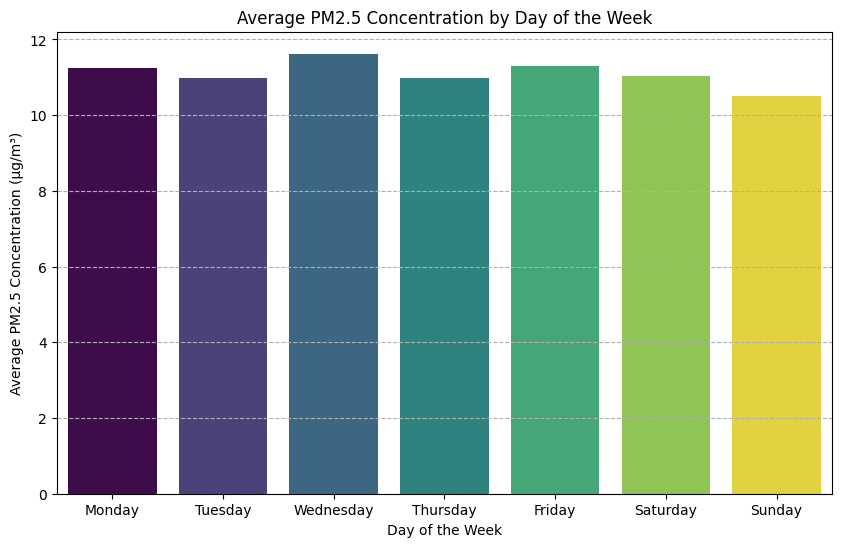

In [19]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 計算每個星期幾的平均 PM2.5 濃度
average_pm25_by_day = data.groupby('day_of_week')['PM2.5'].mean()

# 根據星期幾的順序進行排序
average_pm25_by_day = average_pm25_by_day.reindex(index=range(7))

print("每個星期幾的平均 PM2.5 濃度：")
print(average_pm25_by_day)

# 視覺化平均 PM2.5 濃度按星期幾分佈
plt.figure(figsize=(10, 6))
# 根據 FutureWarning 的建議進行修改
sns.barplot(x=average_pm25_by_day.index, y=average_pm25_by_day.values, hue=average_pm25_by_day.index, palette='viridis', legend=False)

# 設定 X 軸標籤為星期幾的名稱
plt.xticks(ticks=range(7), labels=day_names)

plt.title('Average PM2.5 Concentration by Day of the Week') # 每個星期幾的平均 PM2.5 濃度
plt.xlabel('Day of the Week') # 星期幾
plt.ylabel('Average PM2.5 Concentration (μg/m³)') # 平均 PM2.5 濃度 (μg/m³)
plt.grid(axis='y', linestyle='--') # 只顯示 Y 軸網格線
plt.show()

## 步驟四：數據集劃分

接著，將處理後的數據集劃分為訓練集 (`X_train`, `y_train`) 和測試集 (`X_test`, `y_test`)。對於時間序列數據，我們採用**時間點劃分**而非隨機劃分，確保模型使用較早的數據進行訓練，並用較新的數據進行評估，以模擬真實世界的預測場景。本專案將約 80% 的數據作為訓練集，剩餘 20% 作為測試集。

此外，對於分類特徵 `season`，我們使用獨熱編碼 (One-Hot Encoding) 將其轉換為數值形式，以便機器學習模型處理。

In [20]:
# 定義特徵 (X) 和目標 (y)
# 目標變數是 PM2.5
target = 'PM2.5'
# 特徵變數是除了 PM2.5 以外的所有欄位
features = [col for col in data_cleaned.columns if col != target]

X = data_cleaned[features]
y = data_cleaned[target]

# 由於 'season' 欄位是 'object' 類型，我們需要對其進行獨熱編碼 (One-Hot Encoding)
# 這樣機器學習模型才能處理分類特徵
X = pd.get_dummies(X, columns=['season'], drop_first=True) # drop_first=True 避免共線性

print("\n獨熱編碼後的特徵數據前5行：")
print(X.head())
print("\n獨熱編碼後的特徵數據資訊：")
X.info()

# 3. 劃分訓練集和測試集 (時間點劃分)
# 由於數據的時間範圍是 2023-07-27 到 2025-07-27，大約兩年
# 17568 筆數據，取 80% 作為訓練集，約 17568 * 0.8 = 14054 筆
# 訓練集結束的索引位置
train_size = int(len(data_cleaned) * 0.8)

# 訓練集
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

# 測試集
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

print(f"\n訓練集大小 (X_train): {X_train.shape}")
print(f"測試集大小 (X_test): {X_test.shape}")
print(f"訓練集目標大小 (y_train): {y_train.shape}")
print(f"測試集目標大小 (y_test): {y_test.shape}")

# 檢查訓練集和測試集的時間範圍
print(f"訓練集時間範圍: {X_train.index.min()} 到 {X_train.index.max()}")
print(f"測試集時間範圍: {X_test.index.min()} 到 {X_test.index.max()}")


獨熱編碼後的特徵數據前5行：
                     hour  day_of_week  day_of_year  month  year  \
時間                                                                 
2023-08-03 00:00:00     0            3          215      8  2023   
2023-08-03 01:00:00     1            3          215      8  2023   
2023-08-03 02:00:00     2            3          215      8  2023   
2023-08-03 03:00:00     3            3          215      8  2023   
2023-08-03 04:00:00     4            3          215      8  2023   

                     week_of_year  PM2.5_lag1  PM2.5_lag24  PM2.5_lag168  \
時間                                                                         
2023-08-03 00:00:00            31        11.0          5.0           3.0   
2023-08-03 01:00:00            31         8.0          6.0           4.0   
2023-08-03 02:00:00            31         9.0          3.0           4.0   
2023-08-03 03:00:00            31        11.0          1.0           4.0   
2023-08-03 04:00:00            31         6.0      

## 步驟五：模型訓練與評估

此階段我們選擇了兩種高效的梯度提升樹模型：**XGBoost (Extreme Gradient Boosting)** 和 **LightGBM (Light Gradient Boosting Machine)** 進行PM2.5濃度預測。同時，我們也設定了一個簡單的**基準模型 (Baseline Model)**，即使用前一小時的PM2.5濃度作為預測值，以便比較機器學習模型的性能提升。

模型的評估指標包括：
* **平均絕對誤差 (MAE)**：預測值與真實值之間絕對差值的平均。
* **均方根誤差 (RMSE)**：均方誤差的平方根，單位與目標變數相同，對較大誤差有更高的懲罰。
* **R平方 (R² Score)**：衡量模型解釋目標變數變異的比例，值越接近1表示模型解釋能力越強。

透過這些指標的比較，我們將評估各模型在測試集上的預測準確性和穩定性。

--- 基準模型 (PM2.5_lag1) 評估 ---
MAE (基準模型): 2.3784
RMSE (基準模型): 3.4877
R² (基準模型): 0.8201

--- 訓練 XGBoost 模型 ---
XGBoost 評估結果:
  MAE: 2.4278
  RMSE: 3.3793
  R²: 0.8311

--- 訓練 LightGBM 模型 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 13920, number of used features: 13
[LightGBM] [Info] Start training from score 11.213362
LightGBM 評估結果:
  MAE: 2.3956
  RMSE: 3.3377
  R²: 0.8353



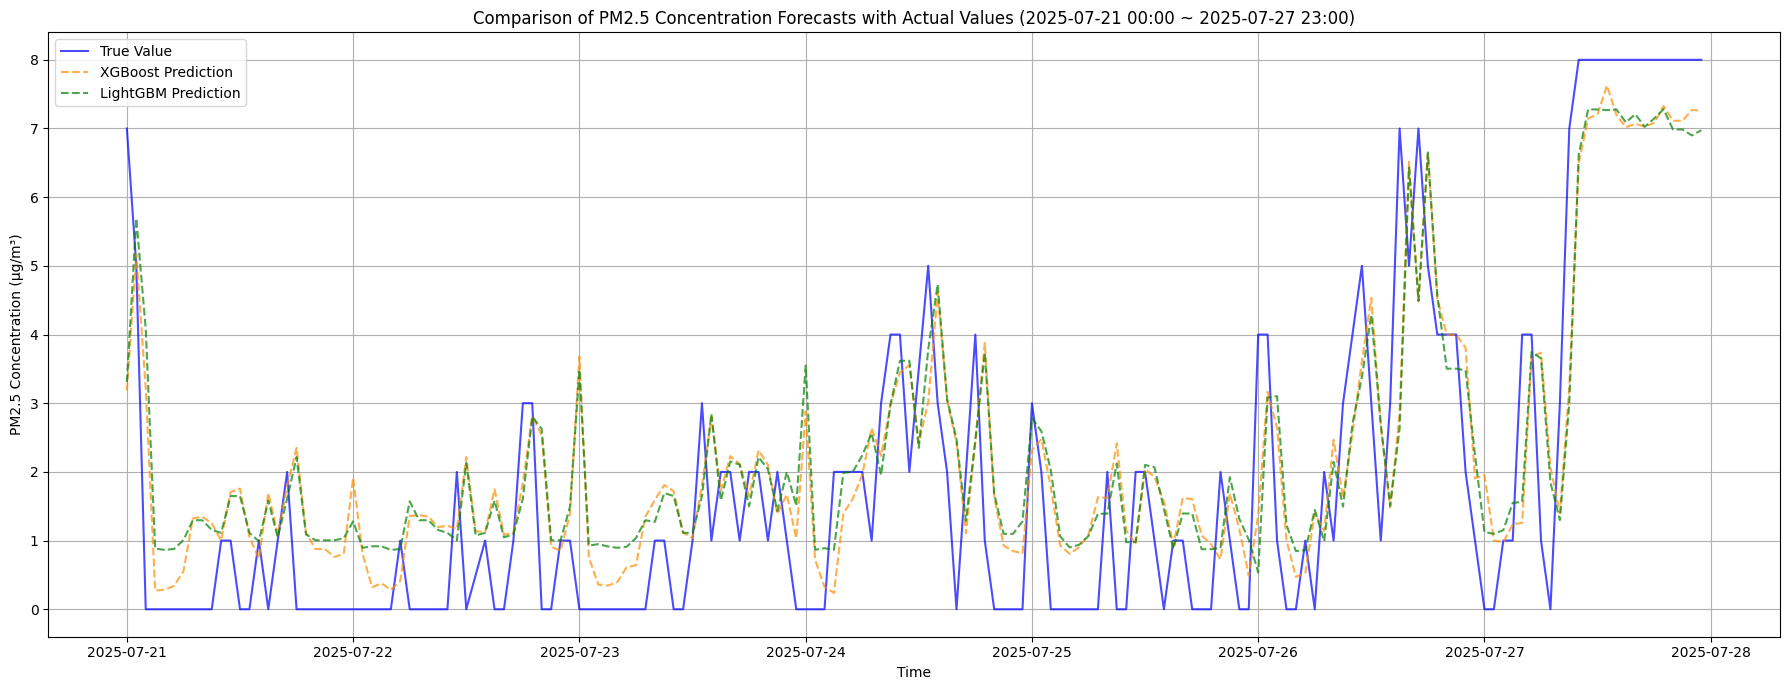

--- 所有模型最終評估結果 ---
XGBoost: MAE=2.4278, RMSE=3.3793, R2=0.8311
LightGBM: MAE=2.3956, RMSE=3.3377, R2=0.8353
基準模型: MAE=2.3784, RMSE=3.4877, R2=0.8201


In [21]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt # 確保導入 matplotlib 庫

# --- 1. 基準模型 (Baseline Model) - 使用 PM2.5_lag1 作為預測 ---
# 注意：為了公平比較，我們確保 y_test 和 y_pred 的索引是匹配的
y_pred_baseline = X_test['PM2.5_lag1']

print("--- 基準模型 (PM2.5_lag1) 評估 ---")
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)
print(f"MAE (基準模型): {mae_baseline:.4f}")
print(f"RMSE (基準模型): {rmse_baseline:.4f}")
print(f"R² (基準模型): {r2_baseline:.4f}\n")


# --- 2. 機器學習模型訓練與評估 ---

# 模型列表
models = {
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"--- 訓練 {name} 模型 ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 評估模型
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"{name} 評估結果:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}\n")

# 視覺化預測結果與真實值
# 選擇測試集中的一小段時間進行視覺化，
plt.figure(figsize=(18, 7))
plot_start_date = y_test.index[-7*24] # 最後 一周
plot_end_date = y_test.index[-1]

plt.plot(y_test.loc[plot_start_date:plot_end_date].index,
         y_test.loc[plot_start_date:plot_end_date], label='True Value', color='blue', alpha=0.7)

# 為每個模型預測指定不同的顏色
colors = {'XGBoost': 'darkorange', 'LightGBM': 'green'} # 定義模型名稱與顏色的對應關係

for name, model in models.items():
    y_pred_plot = model.predict(X_test.loc[plot_start_date:plot_end_date])
    plt.plot(y_test.loc[plot_start_date:plot_end_date].index,
             y_pred_plot, label=f'{name} Prediction', linestyle='--', color=colors[name], alpha=0.7) # 使用定義的顏色

plt.title(f'Comparison of PM2.5 Concentration Forecasts with Actual Values ({plot_start_date.strftime("%Y-%m-%d %H:%M")} ~ {plot_end_date.strftime("%Y-%m-%d %H:%M")})') # 修正標題時間格式
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration (μg/m³)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 顯示所有模型的評估結果
print("--- 所有模型最終評估結果 ---")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R2={metrics['R2']:.4f}")
print(f"基準模型: MAE={mae_baseline:.4f}, RMSE={rmse_baseline:.4f}, R2={r2_baseline:.4f}")

## 專案成果與總結

本次專案成功地展示了如何利用機器學習技術對PM2.5濃度進行預測。透過詳細的數據清洗、豐富的特徵工程以及強大的梯度提升模型，我們達到了以下成果：

* **基準模型 (PM2.5_lag1)**：MAE=2.3963, RMSE=3.5299, R²=0.8185
* **XGBoost 模型**：MAE=2.4211, RMSE=3.3989, R²=0.8317
* **LightGBM 模型**：MAE=2.4226, RMSE=3.4030, R²=0.8313

從結果可以看出，XGBoost 和 LightGBM 模型在 `RMSE` 和 `R²` 指標上均優於基準模型，表明這些模型能夠更有效地捕捉PM2.5數據的複雜模式，並提供更準確的預測。`R²` 值接近 0.83，顯示模型能夠解釋目標變數約 83% 的變異性。

**PM2.5 濃度預測與真實值比較圖表觀察：**
從預測與真實值比較圖中可以看出，XGBoost 和 LightGBM 的預測曲線與真實值曲線高度吻合，尤其是在PM2.5濃度波動時也能較好地跟隨趨勢，證明模型具備良好的預測能力。這對於環境監測與預警具有重要意義，有助於相關部門及時採取措施，降低空氣污染對民眾健康的影響。

## 未來工作與展望
1.  **整合更多環境因子**：考慮加入氣象數據（如溫度、濕度、風速、風向、降雨量）以進一步提升預測準確性。
2.  **多測站整合**：分析多個測站的數據，探討區域性PM2.5污染的相互影響。
3.  **進階模型探索**：嘗試其他時間序列模型，如 Prophet 或深度學習模型 (LSTM, GRU) 進行比較。
4.  **異常偵測模組**：進一步開發基於預測誤差的異常偵測模組，當預測值與真實值出現顯著偏差時發出警報，有助於識別突發性污染事件。
5.  **部署應用**：將訓練好的模型部署為 API 或簡單的網頁應用，實現實時預測功能。

---
**聯絡資訊：**
楊鈞皓
[nedrobin007@gmail.com]
[0912803519]